In [54]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
import albumentations as A # library for data augmenations
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
import os

## Uploading of three different datasets and their processing through preprocessing

Agriadapt (ag) dataset

In [56]:
tags = ['valid', 'train', 'test']
ag_images = []
ag_labels = []
with ZipFile('Agriadapt_archive.zip', 'r') as archive:
  files = archive.namelist()
  for i in tags:
    # images
    images = [f for f in files if '/' + i + '/images' in f]

    for file in images:
      if file.lower().endswith(('.jpg')):
        ag_images.append(file)

    # labels
    labels = [f for f in files if '/' + i + '/labels' in f]
    for file in labels:
      if file.lower().endswith(('.txt')):
          ag_labels.append(file)

  for img_file in ag_images:
    archive.extract(img_file, 'ag_images')

  for lbl_file in ag_labels:
    archive.extract(lbl_file, 'ag_labels')

Chicory crop (ch) dataset

In [57]:
tags = ['train', 'test']
ch_images = []
ch_labels = []
with ZipFile('Chicory crop_archive.zip', 'r') as archive:
  files = archive.namelist()
  for i in tags:
    # images
    images = [f for f in files if '/' + i + '/images' in f]

    for file in images:
      if file.lower().endswith(('.jpg')):
        ch_images.append(file)

    # labels
    labels = [f for f in files if '/' + i + '/labels' in f]
    for file in labels:
      if file.lower().endswith(('.txt')):
          ch_labels.append(file)

  for img_file in ch_images:
    archive.extract(img_file, 'ch_images')

  for lbl_file in ch_labels:
    archive.extract(lbl_file, 'ch_labels')

Tobacco (to) dataset

In [58]:
to_images = []
to_labels = []
with ZipFile('Tobacco_archive.zip', 'r') as archive:
  files = archive.namelist()
  # images
  images = [f for f in files if '/data' in f]

  for file in images:
    if file.lower().endswith(('.png')):
      to_images.append(file)

  # labels
  labels = [f for f in files if '/maskref' in f]

  for file1 in labels:
    if file1.lower().endswith(('.png')):
      to_labels.append(file1)

  for img_file in to_images:
    archive.extract(img_file, 'to_images')

  for lbl_file in to_labels:
    archive.extract(lbl_file, 'to_labels')

Creation of polygon coordinates for Tobacco dataset

In [59]:
to_polygon_masks = [] # polygon annotations for each image
for i in range(len(to_images)):
  img_path = os.path.join('to_images', to_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask_path = os.path.join('to_labels', to_labels[i])
  mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

  contours, _ = cv2.findContours(
    (mask == 255).astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

  polygons = []

  for cnt in contours:
    epsilon = 0.001 * cv2.arcLength(cnt, True)
    polygon = cv2.approxPolyDP(cnt, epsilon, True)
    polygons.append(polygon)

  to_polygon_masks.append(polygons)

In [60]:
len(to_images)

2520

Checking sizes of images

In [61]:
a =  os.path.join('ag_images', ag_images[0])
a = cv2.imread(a)
b = os.path.join('ch_images', ch_images[0])
b = cv2.imread(b)
c = os.path.join('to_images', to_images[0])
c = cv2.imread(c)
a.shape, b.shape, c.shape

((1280, 1280, 3), (416, 416, 3), (352, 480, 3))

As every datset contatins images of different sizes, it's necessary to transform them into one size, whick i took to be equal to 512 by 512 pixels, including masks

In [62]:
# Agriadapt dataset
from pathlib import Path

resized_ag_images = []
resized_ag_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

for i in range(len(ag_images)):
  img_path = os.path.join('ag_images', ag_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  txt_path = os.path.join('ag_labels', ag_labels[i])
  with open(txt_path) as f:
    lines = [list(map(float, line.strip().split())) for line in f]

  bboxes = []
  class_labels = []
  for line in lines:
    if int(line[0]) == 1:
      class_labels.append(int(line[0]))
      x_center, y_center, width, height = line[1], line[2], line[3], line[4]
      x_min = max(0, x_center - width/2)
      y_min = max(0, y_center - height/2)
      x_max = min(1, x_center + width/2)
      y_max = min(1, y_center + height/2)

      # Return valid YOLO format (recalculated to ensure consistency)
      new_width = x_max - x_min
      new_height = y_max - y_min
      new_x_center = x_min + new_width/2
      new_y_center = y_min + new_height/2
      bboxes.append([new_x_center, new_y_center, new_width, new_height])

  transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
  resized_ag_images.append(transformed['image'])

  labels = []
  for class_id, bbox in zip(transformed['class_labels'], transformed['bboxes']):
    labels.append([bbox[0], bbox[1], bbox[2], bbox[3]])

  resized_ag_labels.append(labels)

In [63]:
# Chicory crop dataset
resized_ch_images = []
resized_ch_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

for i in range(len(ch_images)):
  img_path = os.path.join('ch_images', ch_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  txt_path = os.path.join('ch_labels', ch_labels[i])
  with open(txt_path) as f:
    lines = [list(map(float, line.strip().split())) for line in f]

  bboxes = []
  class_labels = []
  for line in lines:
    if int(line[0]) == 0:
      class_labels.append(int(line[0]))
      x_center, y_center, width, height = line[1], line[2], line[3], line[4]
      x_min = max(0, x_center - width/2)
      y_min = max(0, y_center - height/2)
      x_max = min(1, x_center + width/2)
      y_max = min(1, y_center + height/2)

      # Return valid YOLO format (recalculated to ensure consistency)
      new_width = x_max - x_min
      new_height = y_max - y_min
      new_x_center = x_min + new_width/2
      new_y_center = y_min + new_height/2
      bboxes.append([new_x_center, new_y_center, new_width, new_height])

  transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
  resized_ch_images.append(transformed['image'])

  labels = []
  for class_id, bbox in zip(transformed['class_labels'], transformed['bboxes']):
    labels.append([bbox[0], bbox[1], bbox[2], bbox[3]])

  resized_ch_labels.append(labels)

In [64]:
# Tobacco dataset
resized_to_images = []
resized_to_labels = []

transform = A.Compose(
    [A.Resize(height=512, width=512, interpolation=cv2.INTER_LINEAR)])

for i in range(len(to_images)):
  img_path = os.path.join('to_images', to_images[i])
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  mask_path = os.path.join('to_labels', to_labels[i])
  mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

  transformed = transform(image=img)
  transformed1 = transform(image=mask)

  resized_to_images.append(transformed['image'])
  resized_to_labels.append(transformed1['image'])

In [65]:
new_to_polygon_masks = [] # polygon annotations for each image
for i in range(len(to_images)):
  mask = resized_to_labels[i].copy()

  contours, _ = cv2.findContours(
    (mask == 255).astype(np.uint8),
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)

  polygons = []

  for cnt in contours:
    epsilon = 0.001 * cv2.arcLength(cnt, True)
    polygon = cv2.approxPolyDP(cnt, epsilon, True)
    polygons.append(polygon)

  new_to_polygon_masks.append(polygons)

Depiction of one image from each dataset

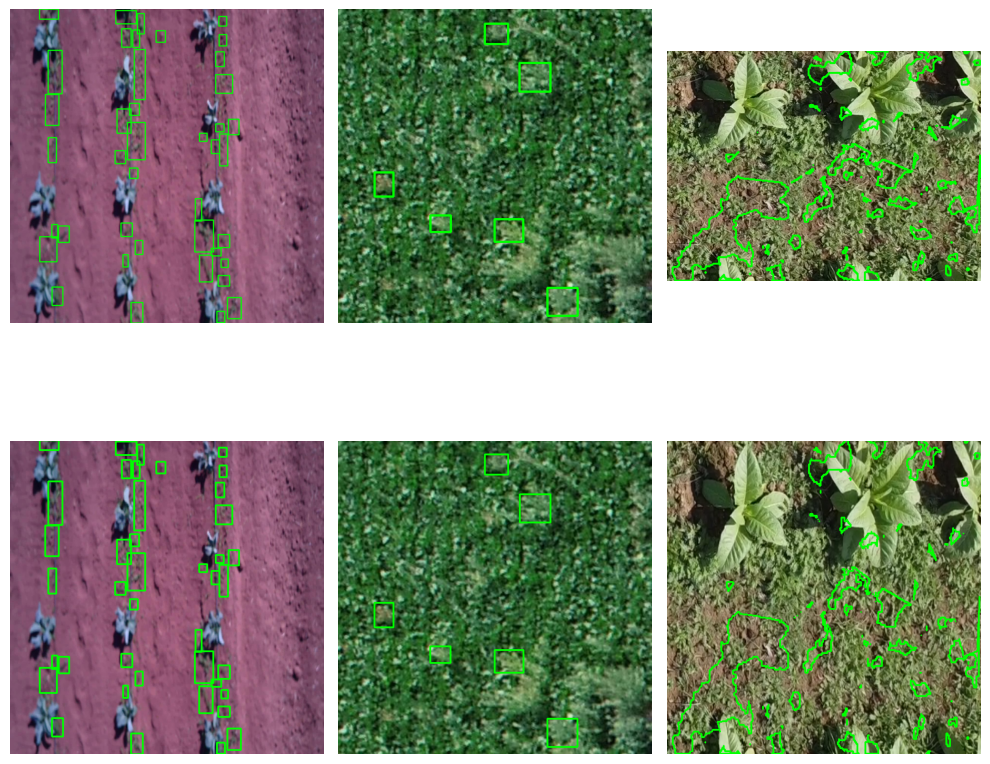

In [66]:
# Resized images (512 by 512)
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

## - - -Upper row - - -
# Agriadapt
img_path = os.path.join('ag_images', ag_images[0])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

txt_path = os.path.join('ag_labels', ag_labels[0])
with open(txt_path) as f:
  lines = [list(map(float, line.strip().split())) for line in f]

for i in lines:
  if int(i[0]) == 1:
    x = i[1] - i[3]/2
    y = i[2] - i[4]/2
    x1 = i[1] + i[3]/2
    y1 = i[2] + i[4]/2

    x, y, x1, y1 = int(x*1280), int(y*1280), int(x1*1280), int(y1*1280)
    cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=4)

axs[0, 0].imshow(img)
axs[0, 0].axis('off')

# Chicory crop
img_path = os.path.join('ch_images', ch_images[256])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

txt_path = os.path.join('ch_labels', ch_labels[256])
with open(txt_path) as f:
  lines = [list(map(float, line.strip().split())) for line in f]

for i in lines:
  if int(i[0]) == 0:
    x = i[1] - i[3]/2
    y = i[2] - i[4]/2
    x1 = i[1] + i[3]/2
    y1 = i[2] + i[4]/2

    x, y, x1, y1 = int(x*416), int(y*416), int(x1*416), int(y1*416)
    cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[0, 1].imshow(img)
axs[0, 1].axis('off')

# Tobacco dataset
img_path = os.path.join('to_images', to_images[863])
# print(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in to_polygon_masks[863]:
  cv2.drawContours(img, [i], -1, (0,255,0), 2)

axs[0, 2].imshow(img)
axs[0, 2].axis('off')

# - - -Lower row - - -
# Agriadapt
img = resized_ag_images[0].copy()
for i in resized_ag_labels[0]:
  x = i[0] - i[2]/2
  y = i[1] - i[3]/2
  x1 = i[0] + i[2]/2
  y1 = i[1] + i[3]/2

  x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
  cv2.rectangle(img, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[1, 0].imshow(img)
axs[1, 0].axis('off')

# Chicory crop
img1 = resized_ch_images[256].copy()
for i in resized_ch_labels[256]:
  x = i[0] - i[2]/2
  y = i[1] - i[3]/2
  x1 = i[0] + i[2]/2
  y1 = i[1] + i[3]/2

  x, y, x1, y1 = int(x*512), int(y*512), int(x1*512), int(y1*512)
  cv2.rectangle(img1, (x, y), (x1, y1), color=(0, 255, 0), thickness=2)

axs[1, 1].imshow(img1)
axs[1, 1].axis('off')

# Tobacco dataset
img1 = resized_to_images[863].copy()

for i in new_to_polygon_masks[863]:
  cv2.drawContours(img1, [i], -1, (0,255,0), 2)

axs[1, 2].imshow(img1)
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Data augmentation

Weather simulation together with scaling, rotation, flipping

In [67]:
# - - -Light Haze/Fog
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha = random.uniform(0.05, 0.25)
  brightness_coef = random.uniform(0.05, 0.25)
  saturation_coef = random.uniform(0.1, 0.2)
  contrast_coef = random.uniform(0.1, 1)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(fog_coef_range=(0.1, 0.35), alpha_coef=alpha, p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_1 = []
agiadapt_lbl_1 = []
chicory_img_1 = []
chicory_lbl_1 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [135, 240]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_1.append(loc_img)
  agiadapt_lbl_1.append(loc_lbl)
  if i == 6:
      break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [130, 200]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_1.append(loc_img)
  chicory_lbl_1.append(loc_lbl)
  if i == 6:
    break

In [68]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha = random.uniform(0.05, 0.25)
  brightness_coef = random.uniform(0.05, 0.25)
  saturation_coef = random.uniform(0.1, 0.2)
  contrast_coef = random.uniform(0.1, 1)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(fog_coef_range=(0.1, 0.25), alpha_coef=alpha, p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1)],
      seed = seed_num)
  return transform

tobacco_img_1 = []
tobacco_lbl_1 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [125, 150]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_1.append(loc_img)
  tobacco_lbl_1.append(loc_lbl)
  if i == 6:
    break

In [69]:
# - - -Light rain and dew (роса)
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  drop_l = random.randint(5, 20)
  drop_w = random.randint(1, 3)
  value = random.randint(195, 210)
  drop_c = (value, value, value)
  blur_v = random.randint(1, 8)
  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomRain(drop_length=drop_l, drop_width=drop_w, drop_color=drop_c, blur_value=blur_v, brightness_coefficient=brightness_coef, rain_type="drizzle" ,p=1)],
      # A.ColorJitter(brightness=(1, 1), saturation=saturation_coef, contrast=contrast_coef, p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_2 = []
agiadapt_lbl_2 = []
chicory_img_2 = []
chicory_lbl_2 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 600]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_2.append(loc_img)
  agiadapt_lbl_2.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [130, 200]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_2.append(loc_img)
  chicory_lbl_2.append(loc_lbl)
  if i == 6:
    break

In [70]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  drop_l = random.randint(5, 20)
  drop_w = random.randint(1, 3)
  value = random.randint(195, 210)
  drop_c = (value, value, value)
  blur_v = random.randint(1, 8)
  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomRain(drop_length=drop_l, drop_width=drop_w, drop_color=drop_c, blur_value=blur_v, brightness_coefficient=brightness_coef, rain_type="drizzle" ,p=1)],
      # A.ColorJitter(brightness=(1, 1), saturation=saturation_coef, contrast=contrast_coef, p=1)],
      seed = seed_num)
  return transform

tobacco_img_2 = []
tobacco_lbl_2 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [125, 150]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_2.append(loc_img)
  tobacco_lbl_2.append(loc_lbl)
  if i == 6:
    break

In [71]:
# - - -Sun with flare
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(250, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  num = random.randint(1, 5)
  brightness_coef = random.uniform(1.1, 1.4)
  saturation_coef = random.uniform(1.1, 1.25)
  contrast_coef = random.uniform(1.1, 1.3)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomSunFlare(flare_roi=(0, 0, 1, 1),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=1)],
      # A.ColorJitter(brightness=0.3, hue=0.05, p=0.5)],  # Boost warmth
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_3 = []
agiadapt_lbl_3 = []
chicory_img_3 = []
chicory_lbl_3 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [138, 160]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_3.append(loc_img)
  agiadapt_lbl_3.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [130, 200]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_3.append(loc_img)
  chicory_lbl_3.append(loc_lbl)
  if i == 6:
    break

C:\Users\Kirill\AppData\Local\Temp\ipykernel_9100\4118563751.py:27: UserWarning: Argument(s) 'stc_radius' are not valid for transform RandomSunFlare
  A.RandomSunFlare(flare_roi=(0, 0, 1, 1),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),


In [72]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(250, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  num = random.randint(1, 5)
  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomSunFlare(flare_roi=(0, 0, 1, 1),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=1)],
      # A.ColorJitter(brightness=0.3, hue=0.05, p=0.5)],  # Boost warmth
      seed = seed_num)
  return transform

tobacco_img_3 = []
tobacco_lbl_3 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [100, 160]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_3.append(loc_img)
  tobacco_lbl_3.append(loc_lbl)
  if i == 6:
    break

C:\Users\Kirill\AppData\Local\Temp\ipykernel_9100\2506603436.py:23: UserWarning: Argument(s) 'stc_radius' are not valid for transform RandomSunFlare
  A.RandomSunFlare(flare_roi=(0, 0, 1, 1),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1),


In [73]:
# - - - Dust storm
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, hue=saturation_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_4 = []
agiadapt_lbl_4 = []
chicory_img_4 = []
chicory_lbl_4 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [450, 625]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_4.append(loc_img)
  agiadapt_lbl_4.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_4.append(loc_img)
  chicory_lbl_4.append(loc_lbl)
  if i == 6:
    break

In [74]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, hue=saturation_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      seed = seed_num)
  return transform

tobacco_img_4 = []
tobacco_lbl_4 =[]

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask = resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_4.append(loc_img)
  tobacco_lbl_4.append(loc_lbl)

  if i == 6:
    break

In [75]:
# - - - Dust storm
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, saturaion=saturation_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_5 = []
agiadapt_lbl_5 = []
chicory_img_5 = []
chicory_lbl_5 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [450, 625]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_5.append(loc_img)
  agiadapt_lbl_5.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_5.append(loc_img)
  chicory_lbl_5.append(loc_lbl)
  if i == 6:
    break

C:\Users\Kirill\AppData\Local\Temp\ipykernel_9100\2572293071.py:26: UserWarning: Argument(s) 'saturaion' are not valid for transform ColorJitter
  A.ColorJitter(brightness=brightness_coef, saturaion=saturation_coef, p=1),


In [76]:
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 1)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.05, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomFog(alpha_coef=alpha_c, fog_coef_range=(0.35, 0.55), p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, p=1),
      A.MotionBlur(blur_limit=(9, 15), p=0.5)],
      seed = seed_num)
  return transform

tobacco_img_5 = []
tobacco_lbl_5 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [450, 625]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_5.append(loc_img)
  tobacco_lbl_5.append(loc_lbl)
  if i == 6:
    break

In [77]:
# - - - Cloudy weather
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=0.4),
      A.ColorJitter(brightness=brightness_coef, hue=saturation_coef, contrast=contrast_coef, p=1),
      A.GaussianBlur(blur_limit=(9, 15), p=0.5)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_6 = []
agiadapt_lbl_6 = []
chicory_img_6 = []
chicory_lbl_6 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [450, 625]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_6.append(loc_img)
  agiadapt_lbl_6.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_6.append(loc_img)
  chicory_lbl_6.append(loc_lbl)
  if i == 6:
    break

In [78]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_limit=(1, 5), shadow_dimension=shadow_dim, shadow_intensity_range=(0.4, 0.7), p=0.4),
      A.ColorJitter(brightness=brightness_coef, hue=saturation_coef, contrast=contrast_coef, p=1),
      A.GaussianBlur(blur_limit=(9, 15), p=0.5)],
      seed = seed_num)
  return transform

tobacco_img_6 = []
tobacco_lbl_6 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [700, 900]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_6.append(loc_img)
  tobacco_lbl_6.append(loc_lbl)
  if i == 6:
    break

Sensor/Environment Issue

In [79]:
# - - - Dirty Lens (Dust/Smudges)
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ISONoise(color_shift=(0.2, 0.4), intensity=(0.3, 0.65), p=1),
      A.RandomGamma(gamma_limit = (20, 40), p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_7 = []
agiadapt_lbl_7 = []
chicory_img_7 = []
chicory_lbl_7 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [800, 850]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_7.append(loc_img)
  agiadapt_lbl_7.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_7.append(loc_img)
  chicory_lbl_7.append(loc_lbl)
  if i == 6:
    break

In [80]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ISONoise(color_shift=(0.2, 0.4), intensity=(0.3, 0.65), p=1),
      A.RandomGamma(gamma_limit = (20, 40), p=1)],
      seed = seed_num)
  return transform

tobacco_img_7 = []
tobacco_lbl_7 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [700, 900]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_7.append(loc_img)
  tobacco_lbl_7.append(loc_lbl)
  if i == 6:
    break

In [81]:
# - - - Motion Blur
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.MotionBlur(blur_limit=(9, 21), p=1),
      A.GaussianBlur(blur_limit = (3, 8), sigma_limit=(3, 10), p=0.4)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_8 = []
agiadapt_lbl_8 = []
chicory_img_8 = []
chicory_lbl_8 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [800, 850]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_8.append(loc_img)
  agiadapt_lbl_8.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_8.append(loc_img)
  chicory_lbl_8.append(loc_lbl)
  if i == 6:
    break

In [82]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.65, 0.85)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.25)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.MotionBlur(blur_limit=(9, 21), p=1),
      A.GaussianBlur(blur_limit = (3, 8), sigma_limit=(3, 10), p=0.4)],
      seed = seed_num)
  return transform

tobacco_img_8 = []
tobacco_lbl_8 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [700, 900]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_8.append(loc_img)
  tobacco_lbl_8.append(loc_lbl)
  if i == 6:
    break

In [83]:
# - - - Overexposed sensor (too much light)
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(1.6, 2)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.3, 0.6)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, hue=saturation_coef, contrast=contrast_coef, p=1),
      A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_9 = []
agiadapt_lbl_9 = []
chicory_img_9 = []
chicory_lbl_9 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [800, 850]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_9.append(loc_img)
  agiadapt_lbl_9.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [500, 1100]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_9.append(loc_img)
  chicory_lbl_9.append(loc_lbl)
  if i == 6:
    break

C:\Users\Kirill\AppData\Local\Temp\ipykernel_9100\2858381310.py:30: UserWarning: Argument(s) 'stc_radius' are not valid for transform RandomSunFlare
  A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],


In [84]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(1.6, 2)
  saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.3, 0.6)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, saturation=saturation_coef, contrast=contrast_coef, p=1),
      A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],
      seed = seed_num)
  return transform

tobacco_img_9 = []
tobacco_lbl_9 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [700, 900]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_9.append(loc_img)
  tobacco_lbl_9.append(loc_lbl)
  if i == 6:
    break

C:\Users\Kirill\AppData\Local\Temp\ipykernel_9100\3884109658.py:26: UserWarning: Argument(s) 'stc_radius' are not valid for transform RandomSunFlare
  A.RandomSunFlare(flare_roi=(0.4, 0, 0.8, 0.8),stc_radius=rad, src_color=color, angle_range=(0, 0.5), num_flare_circles_range=(1, 5), method = "physics_based",  p=1)],


In [85]:
# - - - low-light noise
def seed_number(seed_num, if_Chicory):
  random.seed(seed_num)
  np.random.seed(seed_num)

  scale_r = (0.5, 1)
  if if_Chicory == True:
    scale_r = (1, 1.65)
  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.6, 0.9)
  # saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=scale_r, rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, contrast=contrast_coef, p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1)],
      bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']), seed = seed_num)
  return transform

agiadapt_img_10 = []
agiadapt_lbl_10 = []
chicory_img_10 = []
chicory_lbl_10 =[]

for i in range(len(resized_ag_images)):
  loc_img = []
  loc_lbl = []
  for s in [1000, 1150]:
    transform = seed_number(s + i, False)
    transform_1 = transform(image = resized_ag_images[i], bboxes=resized_ag_labels[i], class_labels = [1 for l in range(len(resized_ag_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  agiadapt_img_10.append(loc_img)
  agiadapt_lbl_10.append(loc_lbl)
  if i == 6:
    break

for i in range(len(resized_ch_images)):
  loc_img = []
  loc_lbl = []
  for s in [1300, 1500]:
    transform = seed_number(s + i, True)
    transform_1 = transform(image = resized_ch_images[i], bboxes=resized_ch_labels[i], class_labels = [1 for l in range(len(resized_ch_labels[i]))])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["bboxes"])

  chicory_img_10.append(loc_img)
  chicory_lbl_10.append(loc_lbl)
  if i == 6:
    break

In [86]:
def seed_number(seed_num):
  random.seed(seed_num)
  np.random.seed(seed_num)

  rad = random.randint(100, 350)
  val = random.randint(253, 255)
  color = (val, val, val)
  # angle = random.uniform(0, 0.5)
  # num = random.randint(1, 5)
  alpha_c = random.uniform(0.08, 0.25)

  brightness_coef = random.uniform(0.6, 0.9)
  # saturation_coef = random.uniform(0.05, 0.2)
  contrast_coef = random.uniform(0.1, 0.2)

  num_shadows = random.randint(1, 5)
  shadow_dim = random.randint(4, 6)

  transform = A.Compose([
      A.OneOf([
          A.HorizontalFlip(p=1),
          A.VerticalFlip(p=1)],
          p=0.65),
      A.Affine(scale=(0.5, 1), rotate=(-180, 180), rotate_method = "ellipse", p=1),
      A.ColorJitter(brightness=brightness_coef, contrast=contrast_coef, p=1),
      A.ISONoise(color_shift=(0.1, 0.25), intensity=(0.3, 0.65), p=1)],
      seed = seed_num)
  return transform

tobacco_img_10 = []
tobacco_lbl_10 =[]

for i in range(len(resized_to_images)):
  loc_img = []
  loc_lbl = []
  for s in [100, 400]:
    transform = seed_number(s + i)
    transform_1 = transform(image = resized_to_images[i], mask=resized_to_labels[i])
    loc_img.append(transform_1["image"])
    loc_lbl.append(transform_1["mask"])

  tobacco_img_10.append(loc_img)
  tobacco_lbl_10.append(loc_lbl)
  if i == 6:
    break

Train and test split

In [88]:
from sklearn.model_selection import train_test_split as tts

In [125]:
# Combination of arrays into one
yolo_or_polygon = [] # "yolo" or "polygon"
images_train = []
images_test = []
labels_train = []
labels_test = []

# Agriadapt
x_train, x_test, y_train, y_test = tts(resized_ag_images, resized_ag_labels, test_size = 0.3, random_state = 45, shuffle = True)
for j in x_train:
    images_train.append(j)
    yolo_or_polygon.append("yolo")
    
images_train.append(x_train)
images_test.append(x_test)
labels_train.append(y_train)
labels_test.append(y_test)
yolo_or_polygon.append("yolo")

# Chicory
x_train, x_test, y_train, y_test = tts(resized_ch_images, resized_ch_labels, test_size = 0.3, random_state = 45, shuffle = True)
images_train.append(x_train)
images_test.append(x_test)
labels_train.append(y_train)
labels_test.append(y_test)
yolo_or_polygon.append("yolo")

# Tobacco
x_train, x_test, y_train, y_test = tts(resized_to_images, resized_to_labels, test_size = 0.3, random_state = 45, shuffle = True)
images_train.append(x_train)
images_test.append(x_test)
labels_train.append(y_train)
labels_test.append(y_test)
yolo_or_polygon.append("polygon")

In [129]:
images_train.shape()

AttributeError: 'list' object has no attribute 'shape'

In [102]:
arr1 = [agiadapt_img_1, agiadapt_img_2, agiadapt_img_3, agiadapt_img_4, agiadapt_img_5, 
        agiadapt_img_6, agiadapt_img_7, agiadapt_img_8, agiadapt_img_9, agiadapt_img_10]

arr2 = [chicory_img_1, chicory_img_2, chicory_img_3, chicory_img_4, chicory_img_5, 
        chicory_img_6, chicory_img_7, chicory_img_8, chicory_img_9, chicory_img_10]

arr3 = [tobacco_img_1, tobacco_img_2, tobacco_img_3, tobacco_img_4, tobacco_img_5, 
        tobacco_img_6, tobacco_img_7, tobacco_img_8, tobacco_img_9, tobacco_img_10]

arr1_lbl = [agiadapt_lbl_1, agiadapt_lbl_2, agiadapt_lbl_3, agiadapt_lbl_4, agiadapt_lbl_5, 
            agiadapt_lbl_6, agiadapt_lbl_7, agiadapt_lbl_8, agiadapt_lbl_9, agiadapt_lbl_10]

arr2_lbl = [chicory_lbl_1, chicory_lbl_2, chicory_lbl_3, chicory_lbl_4, chicory_lbl_5, 
            chicory_lbl_6, chicory_lbl_7, chicory_lbl_8, chicory_lbl_9, chicory_lbl_10]

arr3_lbl = [tobacco_lbl_1, tobacco_lbl_2, tobacco_lbl_3, tobacco_lbl_4, tobacco_lbl_5, 
            tobacco_lbl_6, tobacco_lbl_7, tobacco_lbl_8, tobacco_lbl_9, tobacco_lbl_10]

In [111]:
for i in range(0, 10):
    # Agriadapt
    x_train, x_test, y_train, y_test = tts(arr1[i], arr1_lbl[i], test_size = 0.3, random_state = 45, shuffle = True)
    for j in x_train:
        images_train.append(j[0])
        images_train.append(j[1])
        yolo_or_polygon.append("yolo")

    for j in y_train:
        images_train.append(j[0])
        labels_train.append(j[1])

    for j in x_test:
        images_test.append(j[0])
        images_test.append(j[1])
        yolo_or_polygon.append("yolo")

    for j in y_test:
        labels_test.append(j[0])
        labels_test.append(j[1])
        
    break

    # Chicory


In [113]:
x_train, x_test, y_train, y_test = tts([[1,2],[3,4],[5,6],[7,8],[9,10]], [[11,12],[13,14],[15,16],[17,18],[19,110]], test_size = 0.3, random_state = 45, shuffle = True)

In [114]:
x_train

[[1, 2], [5, 6], [7, 8]]

In [121]:
y_train

[[11, 12], [15, 16], [17, 18]]

In [119]:
[i[0] for i in y_train]

[11, 15, 17]

In [123]:
a = []
for i in y_train:
    a.append(i[0])

In [124]:
a

[11, 15, 17]

In [116]:
qwe = [[1, 4], [2, 3], [7, 9]]
qwe[:,0]

TypeError: list indices must be integers or slices, not tuple

In [44]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# img1 = resized_ag_images[0].copy()
# axs[0].imshow(img1)
# axs[0].axis('off')

# axs[1].imshow(agiadapt_img_2[0][0])
# axs[1].axis('off')

# plt.tight_layout()
# plt.show()

In [100]:
arr1 = [agiadapt_img_1]
arr2 = [chicory_img_1]
arr3 = [tobacco_img_1]

Transformation of maskes into a COco format to train the MobileNet SSD model for polygon prediction